In [1]:
import os
from typing import List, Union, Generator, Iterator
from pydantic import BaseModel
from llama_index.embeddings.ollama import OllamaEmbedding
from llama_index.llms.ollama import Ollama
from llama_index.core import Settings, VectorStoreIndex, SimpleDirectoryReader
import pandas as pd
import json

In [2]:
class RAG:

    class Parameters(BaseModel):
        LLAMAINDEX_OLLAMA_BASE_URL: str
        LLAMAINDEX_MODEL_NAME: str
        LLAMAINDEX_EMBEDDING_MODEL_NAME: str

    def __init__(self):
        self.documents = None
        self.index = None

        self.parameters = self.Parameters(
            LLAMAINDEX_OLLAMA_BASE_URL=os.getenv("LLAMAINDEX_OLLAMA_BASE_URL", "http://localhost:11434"),
            LLAMAINDEX_MODEL_NAME=os.getenv("LLAMAINDEX_MODEL_NAME", "llama3.2:3b"),
            LLAMAINDEX_EMBEDDING_MODEL_NAME=os.getenv("LLAMAINDEX_EMBEDDING_MODEL_NAME", "jina/jina-embeddings-v2-base-en:latest"),
        )

    def on_startup(self):
        Settings.embed_model = OllamaEmbedding(
            model_name=self.parameters.LLAMAINDEX_EMBEDDING_MODEL_NAME,
            base_url=self.parameters.LLAMAINDEX_OLLAMA_BASE_URL,
        )
        Settings.llm = Ollama(
            model=self.parameters.LLAMAINDEX_MODEL_NAME,
            base_url=self.parameters.LLAMAINDEX_OLLAMA_BASE_URL,
        )

        self.documents = SimpleDirectoryReader("test/dataset").load_data()
        self.index = VectorStoreIndex.from_documents(self.documents)

    def on_shutdown(self):
        pass

    def pipe(
        self, user_message: str, model_id: str, messages: List[dict], body: dict, top_k: int = 5
    ) -> Union[str, Generator, Iterator]:
        query_engine = self.index.as_query_engine(streaming=True, top_k=top_k)
        response = query_engine.query(user_message)
        return response.response_gen


def run_query_sync(query: str, top_k: int = 5) -> str:
     rag = RAG()
     rag.on_startup()
     
     user_message = query
     model_id = "llama3.2:3b"
     messages = [{"role": "user", "content": user_message}]
     body = {}
     
     # return top_k vectors (and not the default)
     response_gen = rag.pipe(user_message, model_id, messages, body, top_k=top_k)
     response_text = ''.join(response_gen)

     rag.on_shutdown()
     return response_text

In [3]:
if __name__ == "__main__":

    prompt = f"""
    Classify the following request among the following request categories:
        - Emergency Maintenance (IMBL Scanner Breakdown - Immediate Repair Required)
        - Routine Maintenance (Scheduled Maintenance Request for IMBL Scanner)
        - Upgrades (Request for Software Upgrade on IMBL Scanner)
        - Training (Request for Additional IMBL Scanner Training)
        - Replacement Under Warranty (Request for Replacement of Defective IMBL Scanner Part)
        - Customization (Request for Customization of IMBL Scanner Settings)
        - User-Caused Damage (Repair Request for IMBL Scanner - Accidental Damage)
        - New Projects (Request for Installation and Setup of New IMBL Scanner; Request for Remote Troubleshooting - IMBL Scanner Software Issue)
        - Performance Reports (Request for Detailed Monthly Performance Report)
        - Other (all other requests)

    Then check if the following request is covered under the Service Level Agreement (SLA) or not. Return the relevant passages from the SLA under "context" below.
    
    Then decide if the request is covered by the SLA, in that case the request is Billable, else the request is Not Billable. Also consider the Billable / Not Billable information depending on the request category.

    Return your reply in the following JSON format, nothing else, and follow strictly this format:
    {{
        category: [one of the request category above],
        context: [relevant passage from the Service Level Agreement, do not include the customer request here],
        billable: [Billable / Not Billable]
    }}
    """

    df_questions = pd.read_csv('test/qa/QA_billability.csv')
    df_questions['predicted_category'] = None
    df_questions['predicted_context'] = None
    df_questions['predicted_answer'] = None

    for case_nb in range(df_questions.shape[0]):
        question = df_questions['question'][case_nb]
        query = prompt + question
        response = ""
        print("\n================================")
        print(f'case_nb', case_nb)
        print(f'question:', question)
        
        while True:
            try:
                response = run_query_sync(query, top_k=5)
                response_json = json.loads(response)
                
                pred_category = response_json["category"]
                df_questions.loc[case_nb, 'predicted_category'] = pred_category
                print(f'predicted_category:', pred_category)
                
                pred_context = response_json["context"]
                df_questions.loc[case_nb, 'predicted_context'] = pred_context
                print(f'predicted_context:', pred_context)
                
                pred_billable = response_json["billable"]
                df_questions.loc[case_nb, 'predicted_answer'] = pred_billable
                print(f'predicted_billable:', pred_billable)
                
                print(f'expected_answer:', df_questions['expected_answer'][case_nb])
                print(f'expected_context:', df_questions['context'][case_nb])
                
                if pred_billable == df_questions['expected_answer'][case_nb]:
                    print('Prediction correct')
                else:
                    print('PREDICTION WRONG !!!')
                print("--------------------------------")
                break  # Exit the while loop if the response is correctly parsed
            except json.JSONDecodeError:
                print("JSONDecodeError encountered. Retrying...")

print("Processing completed.")


case_nb 0
question: Subject: IMBL Scanner Breakdown - Immediate Repair Required Dear Support Team, We are experiencing a sudden breakdown of our IMBL Scanner, rendering it non-operational. We request immediate assistance for emergency repairs to restore functionality as soon as possible. Thank you for your prompt attention to this matter. Best regards, [Customer Name]
predicted_category: Emergency Maintenance (IMBL Scanner Breakdown - Immediate Repair Required)
predicted_context: 19.2 Response Times
- Emergency Maintenance: For critical issues that render the Equipment non-operational, the Service Provider shall respond within 2 hours of notification and commence repairs within 4 hours.
predicted_billable: Billable
expected_answer: Billable
expected_context: Emergency maintenance is typically covered but billed separately as per response time clauses
Prediction correct
--------------------------------

case_nb 1
question: Subject: Scheduled Maintenance Request for IMBL Scanner Dear Su

In [4]:
df_csv = df_questions[['question', 'predicted_answer', 'predicted_context']]
df_csv.columns =['question', 'answer', 'context']
df_csv.to_csv('billability_submission.csv')
df_csv

,question,answer,context
0,Subject: IMBL Scanner Breakdown - Immediate Re...,Billable,19.2 Response Times\n- Emergency Maintenance: ...
1,Subject: Scheduled Maintenance Request for IMB...,Not Billable,19.2. Response Times\n- Routine Maintenance Re...
2,Subject: Request for Software Upgrade on IMBL ...,Not Billable,19.2 Response Times - Routine Maintenance Requ...
3,Subject: Request for Additional IMBL Scanner T...,Not Billable,5. Client Responsibilities\nProvide the Servic...
4,Subject: Request for Replacement of Defective ...,Not Billable,19.6. Penalties\n- Service Credits: If the Ser...
5,Subject: Request for Customization of IMBL Sca...,Not Billable,19.5. Reporting\n- Maintenance Reports: The Se...
6,Subject: Request for Detailed Monthly Performa...,Not Billable,19.5. Reporting\n- Maintenance Reports: The Se...
7,Subject: Repair Request for IMBL Scanner - Acc...,Not Billable,Client Actions: Downtime caused by the Client'...
8,Subject: Request for Installation and Setup of...,Billable,The Service Provider agrees to meet the perfor...
9,Subject: Request for Remote Troubleshooting - ...,Not Billable,19.2 Response Times - Routine Maintenance Requ...


In [5]:
df_questions

,question,expected_answer,context,predicted_category,predicted_context,predicted_answer
0,Subject: IMBL Scanner Breakdown - Immediate Re...,Billable,Emergency maintenance is typically covered but...,Emergency Maintenance (IMBL Scanner Breakdown ...,19.2 Response Times\n- Emergency Maintenance: ...,Billable
1,Subject: Scheduled Maintenance Request for IMB...,Not Billable,Routine maintenance is usually included in the...,Routine Maintenance,19.2. Response Times\n- Routine Maintenance Re...,Not Billable
2,Subject: Request for Software Upgrade on IMBL ...,Billable,Routine maintenance is usually included in the...,Upgrades,19.2 Response Times - Routine Maintenance Requ...,Not Billable
3,Subject: Request for Additional IMBL Scanner T...,Billable,Upgrades are generally outside the regular mai...,Training,5. Client Responsibilities\nProvide the Servic...,Not Billable
4,Subject: Request for Replacement of Defective ...,Not Billable,Training services are not part of regular main...,Replacement Under Warranty,19.6. Penalties\n- Service Credits: If the Ser...,Not Billable
5,Subject: Request for Customization of IMBL Sca...,Billable,Replacement under warranty is typically covere...,Customization,19.5. Reporting\n- Maintenance Reports: The Se...,Not Billable
6,Subject: Request for Detailed Monthly Performa...,Billable,Customization generally falls outside standard...,Performance Reports,19.5. Reporting\n- Maintenance Reports: The Se...,Not Billable
7,Subject: Repair Request for IMBL Scanner - Acc...,Billable,If detailed reports are part of the agreed SLA...,User-Caused Damage,Client Actions: Downtime caused by the Client'...,Not Billable
8,Subject: Request for Installation and Setup of...,Billable,User-caused damage is typically not covered un...,New Projects,The Service Provider agrees to meet the perfor...,Billable
9,Subject: Request for Remote Troubleshooting - ...,Not Billable,This would be considered a new project setup a...,New Projects,19.2 Response Times - Routine Maintenance Requ...,Not Billable


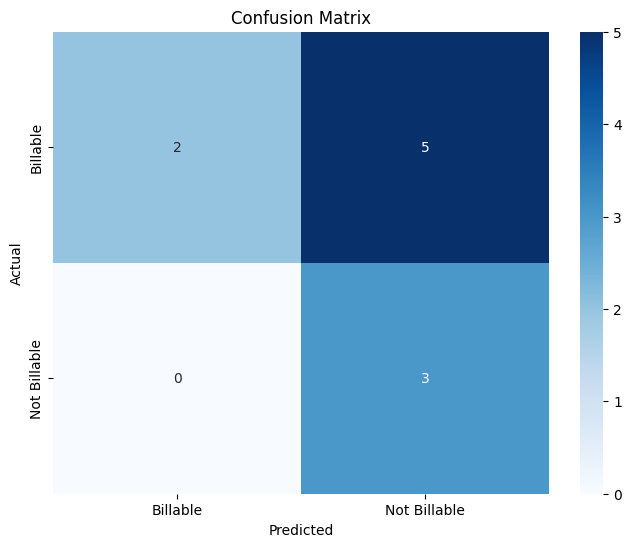

In [6]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Create confusion matrix
conf_matrix = confusion_matrix(df_questions['expected_answer'], df_questions['predicted_answer'], labels=['Billable', 'Not Billable'])

# Create a DataFrame for the confusion matrix
conf_matrix_df = pd.DataFrame(conf_matrix, index=['Billable', 'Not Billable'], columns=['Billable', 'Not Billable'])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [7]:
from sklearn.metrics import accuracy_score
# Calculate accuracy
accuracy = accuracy_score(df_questions['expected_answer'], df_questions['predicted_answer'])
print(f"Accuracy: {accuracy}")

Accuracy: 0.5
